# Final Project: Modeling and forecasting atmospheric CO₂ from 1958 until 2058 
## Oscar Engelbrektson
## CS146, Prof. Scheffler, Fall 2019

In [1]:
#Load libraries
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan
from numpy.polynomial.polynomial import polyfit

In [2]:
#Load dataset
df = pd.read_csv("/Users/oscarengelbrektson/Downloads/weekly_in_situ_co2_mlo(2).csv", delimiter=";", header=0)

In [3]:
df.tail()

,Date,Co2
3134,2019-08-31,409.32
3135,2019-09-07,408.80
3136,2019-09-14,408.61
3137,2019-09-21,408.50
3138,2019-09-28,408.28


The dataset contains weekly measurements of atmospheric carbon dioxide levels collected at the Mauna Loa Observatory, Hawaii from 1958 until today (October, 2019). Athmospheric carbon dioxide concentration is measured in parts per million (ppm). 

The aim of this project is to use this historical dataset to train a model which can then be used to forecast future changes in athmospheric carbon dioxide up to 2058-just less than 40 years into the future. We will be taking a bayesian approach to this problem as it allows us to model the uncertainty in our forecasts. The bayesian posteriors give us valid probability distributions over the outcome of interest. This is preferable taking a frequentist approach, which would entail running the model for different parameter values or "scenarios"–worst case, best case and so on– to reflect uncertainty, because we can model the likelihood of the different scenarios coming true.

Let's plot the dataset so we can see what we are working with.

In [4]:
#Convert dates to datetime format
df["Date"] = pd.to_datetime(df["Date"])

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


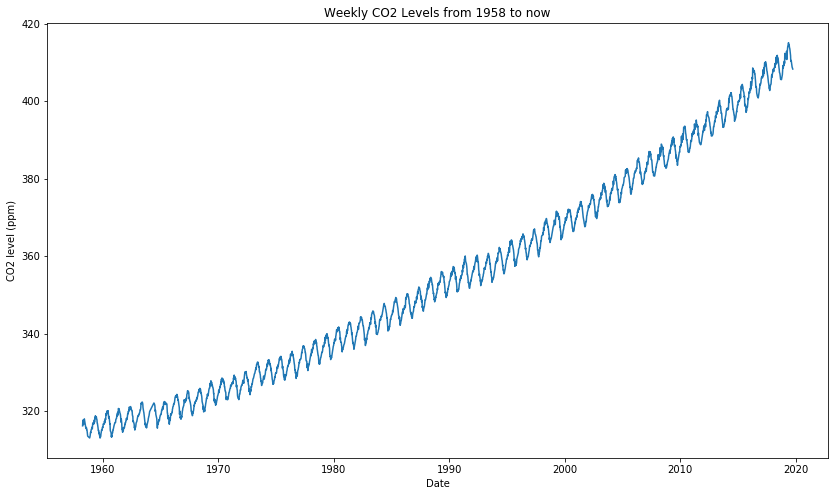

In [8]:
plt.figure(figsize=(14,8))
plt.plot(df["Date"], df["Co2"])
plt.title('Weekly CO2 Levels from 1958 to now')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

We see a strong upwards trend in Co2 levels over time. It is nearly linear, judging visually I would say it is weakly quadratic. Further, we can see that there is strong seasonality, reflected by seemingly equally spaced periods in the C02 levels. 

Let's try zooming in on a shorter timespan to make the nuances clearer. Let's do it from 2010 until now.

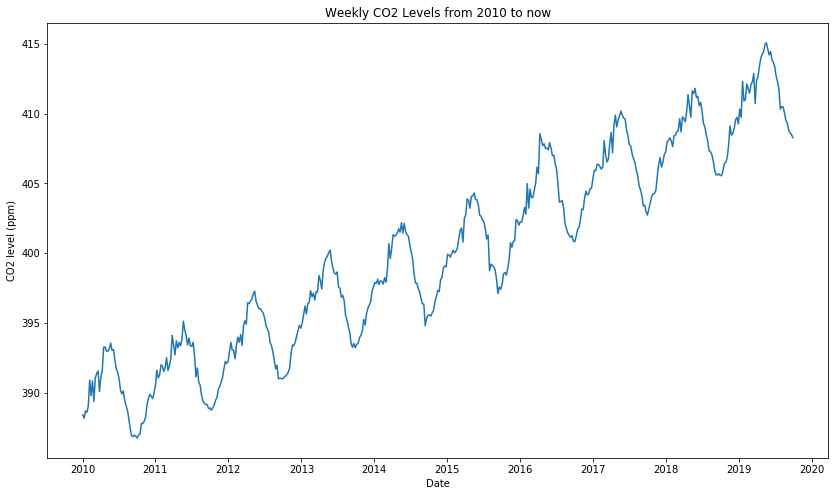

In [14]:
#Find indices of observations made 2010 and after
recent = np.where(df["Date"]>=pd.to_datetime("2010-01-01"))

#Plot
plt.figure(figsize=(14,8))
plt.plot(df["Date"].loc[recent], df["Co2"].loc[recent])
plt.title('Weekly CO2 Levels from 2010 to now')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

In this more zoomed in visualization, we also see that there is some noise, reflected as sporadic variations around the trend and seasonality.

Some research confirms these initial, visual interpretations. The primary causes of the seasonality in the data–faster increases of CO2 levels in the 1st and 4th quarters of the year, and slower increases the 2nd and 3rd quarters of the year–are a) there are more plants in Q2 and Q3 which absorb CO2 through photosynthesis and b) humans consume more fossil fuels in the cold parts of the year (which in is the northern hemisphere, where most consumption takes place, coincides with Q4 and Q1) (Wikipedia, 2019).

To effectively forecast the CO2 levels in the future, our model must effectively capture all these characteristics of the data.
1. The trend
2. The period
3. The noise

My approach to solving this modelling problem will be iterative, breaking the larger modelling task into tractable subproblems:
1. I will start off trying to find an appropriate parameterization for the trend. Specifically, I will evaluate whether it is best estimated using a polynomial of degree 1 (linear) or degree 2 (quadratic). To me, the plot looks lika quadratic would provide a better fit, but let us test this hypothesis.
2. Once I have found a good model for the trend, I will use it to detrend the data. This then allows for the second stage, modelling the seasonality/period.
3. With both trend and period modelled, I can substract them from the data, leaving only the noise. I can then model the noise.
4. I will then combine each of these steps 1-3 into a single model.

# Fitting the trend: linear vs quadratic

This is essentially a regression problem. I will fit both a linear model of the form:

    x = N(a + bt, sigma)

and a quadratic model of the form:
    
    x =  N(a + bt + ct^2, sigma)
    
to the data. I want to fit the trend overall trend of the data as well as possible. As I am only considering polynomials of low order (1 and 2) and the period of data is long there is not really a notable threat of overfitting. Consequently, I will measure the performance of the two models using mean square error. Selecting the model with the lowest MSE. 

In both models, a, b and sigma (and c, in the quadratic model) are unobserved variables over which we will perform inference. Consequently, we will require priors over these variables. x is the co2 level and t is time, i.e. both are data.

Looking at the values around 1958, the value of a, the intercept, seems to be close to 300. Thus, for our prior we have a ~ N(300, 20).

Prior to looking at the data, I knew the average weekly increase in CO2 ppm has to be relatively small, simply because of the short time between readings. I am almost certain it must be less than 1, because otherwise there would have been a more than 3040ppm increase since 1958–which, even if the Co2 ppm was 0 in 1958, I think would be seriously damaging and I know Hawaii is a perfectly fine place to vacation. That said, I think it has been increasing over the last decades, but above and beyond that I really don't know too much. I set b ~ N(0.5, 0.5).

The variance must be positive, by definition. Above and beyond that, I am uncertain of what seems to be a plausible value. We want a wide prior to reflect this.
sigma ~ cauchy(1,1)

#### Creating a numberical representation for the time variable df["Date"]

Stan only takes numerical inputs. To abide by this constraint, I map the datetime objects to ordinals using toordinal() method in pandas. Furthermore, I substract the minimum numerical date plus 1 from all observations, this has the effect of making the date start at 1, and every subsequent observation is made 7 days into the future. This allows us to estimate the intercept a for our models.

This mapping is easily inverted, such that the datetime can easily be recovered from the ordinal representation.

In [5]:
df["Ordinal_date"] = df["Date"].apply(lambda x: x.toordinal())
df["Ordinal_date"] = df["Ordinal_date"]-df["Ordinal_date"].min()
df.head()

,Date,Co2,Ordinal_date
0,1958-03-29,316.19,1
1,1958-04-05,317.31,8
2,1958-04-12,317.69,15
3,1958-04-19,317.58,22
4,1958-04-26,316.48,29


### Linear model

In [6]:
stan_data = {
    "len_data" : df.shape[0], # number of observation in data
    "time" : df["Ordinal_date"], # time since first observation
    "carbon" : df["Co2"] #Co2 level
}

linear_stan_code = """
data {
    int<lower=0> len_data;             // number of observation in data
    real<lower=0> time[len_data];      // time since first observation
    real carbon[len_data];             // #Co2 level
}
parameters {
    real<lower=0> a;  // intercept
    real<lower=0> b;  // slope
    real<lower=0> sigma;        // variance in normal
} 
model {
    a ~ normal(500, 250); //Priors
    b ~ cauchy(0.5, 0.5);
    sigma ~ cauchy(1,1);
    for (i in 1:len_data) {
        carbon[i] ~ normal(a + time[i]*b, sigma); 
    }
}
"""
linear = pystan.StanModel(model_code=linear_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89227fc99169de2e26a5d953a37a52b9 NOW.


In [7]:
#Extract the Stan results
linear_results = linear.sampling(data=stan_data)
linear_samples = linear_results.extract()
print(linear_results.stansummary(pars=['a', "b", "sigma"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_89227fc99169de2e26a5d953a37a52b9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
a     306.06  3.2e-3   0.16 305.75 306.06 306.35   2360    1.0
b     4.3e-3  2.6e-7 1.2e-5 4.3e-3 4.3e-3 4.3e-3   2124    1.0
sigma   4.27  1.7e-3   0.05   4.16   4.27   4.37   1021    1.0

Samples were drawn using NUTS at Wed Dec 18 18:42:22 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Rhat is 1, sampler converged nicely.

Now we estimate the quadratic model for the trend. This has a quadratic term with unobserved variable, coefficient c.

For reasons similar to the prior on b– I suspect the rate of increase has been increasing over time, but I am not sure–I set prior c(0.5, 0.5).

In [8]:
quadratic_stan_code = """
data {
    int<lower=0> len_data;             // number of observation in data
    real<lower=0> time[len_data];      // time since first observation
    real carbon[len_data];             // Co2 level
}
parameters {
    real<lower=0> a;      // intercept
    real<lower=0> b;               // slope
    real<lower=0> c;               // coefficient for quadratic term
    real<lower=0> sigma;  // variance in normal
} 
model {
    a ~ normal(500, 250); //Priors
    b ~ cauchy(5, 5);
    c ~ cauchy(5, 5);
    sigma ~ cauchy(1,1);
    for (i in 1:len_data) {
        carbon[i] ~ normal(a + time[i]*b + c*time[i]^2, sigma); 
    }
}
"""
quadratic = pystan.StanModel(model_code=quadratic_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b17cfb481284667e7f2c7eabdffce8f9 NOW.


In [9]:
#Extract the Stan results
quadratic_results = quadratic.sampling(data=stan_data)
quadratic_samples = quadratic_results.extract()
print(quadratic_results.stansummary(pars=["a","b","c", "sigma"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_b17cfb481284667e7f2c7eabdffce8f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
a     314.57  3.4e-3   0.13 314.32 314.57 314.82   1424    1.0
b     2.1e-3  7.6e-7 2.6e-5 2.0e-3 2.1e-3 2.2e-3   1126    1.0
c     9.7e-8 3.2e-11 1.1e-9 9.5e-8 9.7e-810.0e-8   1131    1.0
sigma   2.25  7.1e-4   0.03    2.2   2.25   2.31   1547    1.0

Samples were drawn using NUTS at Wed Dec 18 18:43:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Rhat is 1, sampler converged nicely.

### Comparing the trendlines

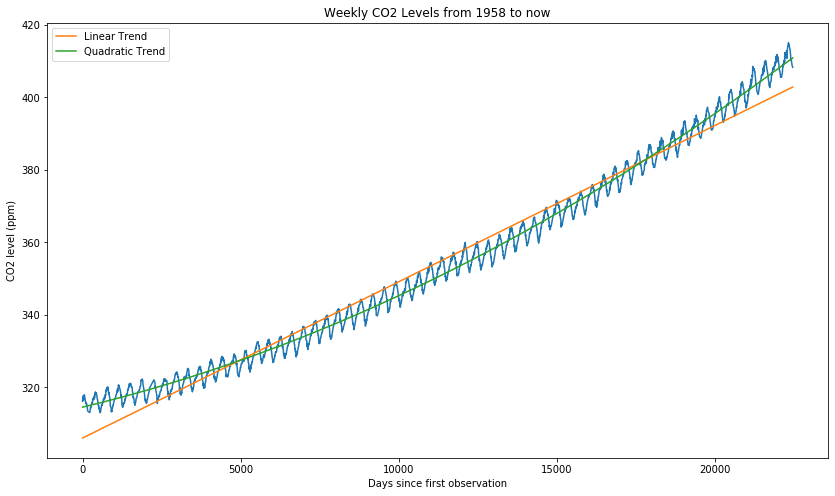

In [157]:
#Extract trendlines by taking the mean the posterior over each parameter 
#and using it as the coefficients in the polynomials
linear_trend = linear_samples["a"].mean() + linear_samples["b"].mean()*df["Ordinal_date"] 

quadratic_trend = quadratic_samples["a"].mean() + quadratic_samples["b"].mean()*df["Ordinal_date"] \
                + quadratic_samples["c"].mean()*df["Ordinal_date"]**2

plt.figure(figsize=(14,8))
plt.plot(df["Ordinal_date"], df["Co2"])
plt.plot(df["Ordinal_date"], linear_trend, label="Linear Trend")
plt.plot(df["Ordinal_date"], quadratic_trend, label="Quadratic Trend")
plt.title('Weekly CO2 Levels from 1958 to now')
plt.xlabel("Days since first observation")
plt.ylabel('CO2 level (ppm)')
plt.legend(loc=0)
plt.show()

Normally, I would compute the some measure of error, like MSE or MAE, to evaluate which model fits the data better, but in this case there is no need: the quadratic fit is considerably better.

The quadratic does a solid job of modelling the trend, we choose to move ahead with this model for the trend.

# Modelling the Period

To fit a model to the period, we begin by detrending the data, such that each period is centered on 0.

In [139]:
#Create a column for the detrended data by subtracting the quadratic trend
#Because Stan only takes positive inputs, we shift the period upwards above the zero line
df["Detrended_co2"] = df["Co2"] - quadratic_trend
#df["Detrended_co2"] += abs(df["Detrended_co2"].min())+1
df.to_csv(r"/Users/oscarengelbrektson/Documents/Minerva/CS146 - Stats/climate_data1.csv", index=False)

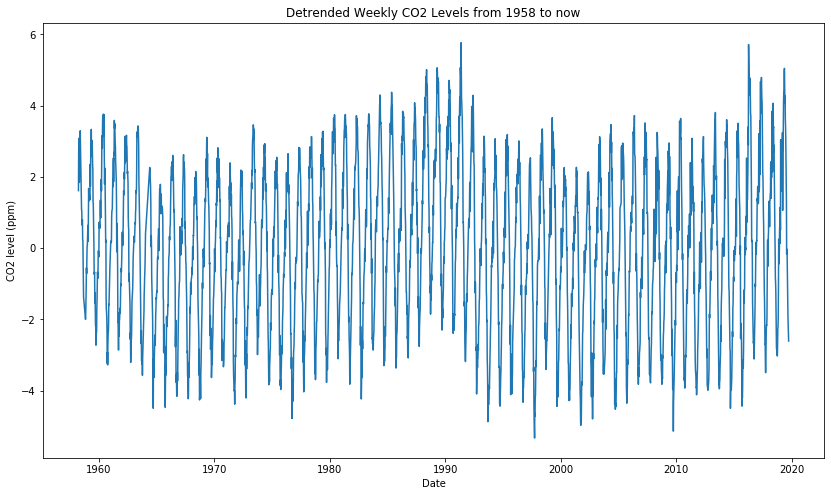

In [140]:
#Visualize the detrended data
plt.figure(figsize=(14,8))
plt.plot(df["Date"], df["Detrended_co2"])
plt.title('Detrended Weekly CO2 Levels from 1958 to now')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

We can see from this plot of the data that has been detrended using our quadratic model, that the quadratic model has done quite a good job of fitting the trend. That is, the fluctuations are centered on 0 on average. However, it is not perfect. Whilst the periods are centered on zero on average, there is some variation over time. There seem to be two 30-year periods: starting 1960 it foes down until 1975 and then back up by 1990; it then repeats this pattern by 2020. Because the period is so long, we only have, at best, two observations of it in the data. hence, its hard to know if this is just happenstance or some systematic cause which we expect to be repeated in the future. Would trying to fit this pattern be overfitting? I see no compelling reason why we would expect this to be a repeating 30-year length pattern to be effecting the seasonality of CO2 levels in the athmosphere and there is not enough evidence in the data to suggest otherwise (n=2), so my answer is yes. However, we may be able to capture this noise in the noise section of the model.

Let's get a closer look at the trends by looking at a shorter timespan.

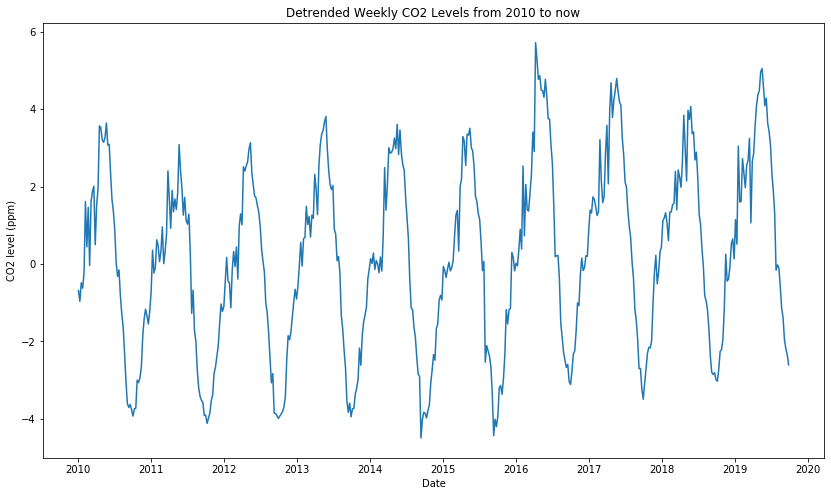

In [141]:
#Zoom in to see period more clearly
plt.figure(figsize=(14,8))
plt.plot(df["Date"].loc[recent], df["Detrended_co2"].loc[recent])
plt.title('Detrended Weekly CO2 Levels from 2010 to now')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.show()

### Interpreting the visualizationsa and reasoning about possible models the period
The time it takes to complete one period seems to be around 1 year. There seems to be more noise in the part of the period that is increasing than in the part that is decreasing–the decreasing part is in many cases almost completely straight. Noise aside, I think the period itself looks approximately symmetric. That is, the time from peak to low is the same as the time from low to peak. If this is the case, an ordinary trigonometric function,  like cos or sin, may be appropriate for modelling the period. Let's try cos for modelling the period.

Simultaneously, whilst it does not look far from it, it does not look symmetric about the peak. It seems like the increase is slower than the decrease. Further, there seems to be more noise in the part of the period that is increasing than in the part that is decreasing–the decreasing part is in many cases almost completely straight. After doing some googling, it looks like it may be possible to capture this by modelling the period using a cos function inside a cos function (Source: "Asymmetric periods in a sine curve" https://math.stackexchange.com/questions/2341764/asymmetric-periods-in-a-sine-curve)

I will try both approaches and see which, when plotted as a line, has the lowest MSE compared to the observed data.

### Breaking down the components of the model
sin(x) = cos(x + C), i.e. they are shifted version of each other. Consequently, we could just as well use sin instead of cos. In fact, I personally prefer using sin, because sin(0)=0, making the phase shift easier to interpret. Thus, I go ahead using sin to model the period:

To make a trigonometric function model the periodicity of the CO2, there are a number of parameters that must be tuned. According to Wikipedia, the general form of a sin function can be expressed as:

    y = A sin(B(x + C)) + D

where:
1. amplitude is A
2. period (distance between peaks)is 2π/B
3. phase shift is C (positive is to the left)
4. vertical shift is D

Adapting this to our specific case:
1. Abiding by our previously defined Bayesian approach, will put all this inside a normal distribution, with noise sigma: N(A cos(B(x + C)) + D, sigma)
1. time (number of days since first observation) is our independent variable.
2. The amplitude, i.e. the height of waves or magnitude of Co2 variation, will be a parameter that we solve for using Stan
3. The period is given by 2π/B. We know from context that the period here is yearly, so we want 2π/B = 365.25 -> B=0.017202423838958484.
3. The phase shift will too be solved for using stan. Note also that sin(x) = cos(x + C), i.e. they are shifted version of each other. Consequently, we could just as well use sin instead of cos.
4. Since we have detrended the data, there will be no vertical shift required for this section. However, when we combine the model for the period and the trend, D = the model for the trend.

For the sake of avoiding overlapping variable names, we shift each of these letters for to the right. A->D, B->E and so on.. 

My trigonometry skills are not the best. In general, my approach to modelling the period has been one of iteration. I try out a model (commonly I have found it does not converge) then try to diagnose the problem using pair plots and stackoverflow. Then try again until I have something that works. To generate diagnostics visualizations–autocorrelation plots and pair plots–I used the code from Session 14.1 PCW (Appended at the end of the assignment).

Similarly, my approach to setting priors has been to set rather wide priors as I don't have much intuition for what the MLE values should be, and don't want to accidentally assign 0 prior probability to good solutions. In the cases where the priors are more precise, it is because I have ran the model a large number of times and learned what are good values–this helps the model run faster, thank god.

In [142]:
#As there is a lot of iteration here, I work with a subset of the data to make the models run faster
#When I have something that looks promising, I will run it with all the data

testing_subset = df[["Ordinal_date", "Detrended_co2"]].loc[recent]

## Modelling the period using a simple sin function

In [125]:
simple_sin_stan_code =  """
data {
    int<lower=0> len_data;             // number of observation in data
    real<lower=0> time[len_data];      // time since first observation
    real carbon[len_data];            // Detrended Co2 level
    real constant;                    // 2pi/period
}
parameters {
    real<lower=0> D;            //  Amplitude
    real E;                     //  
    real<lower=0> sigma;        //  noise / variance
} 
model {
    D ~ cauchy(0, 3);
    E ~ cauchy(0, 3);
    sigma ~ cauchy(0,2);
    for (i in 1:len_data) {
        carbon[i] ~ normal(D*sin(constant*(time[i] + E)), sigma); 
    }
}
"""
simple_sin = pystan.StanModel(model_code=simple_sin_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8c3fd5900de75e616c741e82838a266 NOW.


In [129]:
'''detrended_stan_data = {
    "len_data" : testing_subset.shape[0], # number of observation in data
    "time" : testing_subset["Ordinal_date"], # time since first observation
    "carbon" : testing_subset["Detrended_co2"] #Detrended Co2 level
}
'''

detrended_stan_data = {
    "len_data" : df.shape[0], # number of observation in data
    "time" : df["Ordinal_date"], # time since first observation
    "carbon" : df["Detrended_co2"], #Detrended Co2 level
    "constant": 2*np.pi/365.25 #Period
}

#Extract the Stan results
simple_sin_results = simple_sin.sampling(data=detrended_stan_data) #, control={'max_treedepth': 15, "adapt_delta" : 0.999}

In [130]:
simple_sin_samples = simple_sin_results.extract()
print(simple_sin_results.stansummary(pars=["D", "E", "sigma"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_f8c3fd5900de75e616c741e82838a266.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
D       2.82  2.5e-3   0.16   2.51   2.82   3.14   4229    1.0
E      64.48    0.05   3.43   57.6  64.48  71.24   3909    1.0
sigma   6.42  1.2e-3   0.08   6.27   6.42   6.58   4439    1.0

Samples were drawn using NUTS at Thu Dec 19 20:14:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Impeccable convergence, finally. The famed n_eff > draws, even. No further sampler diagnostics needed; the quality of the model for the period is later compared to the slightly more advanced, distorted period model.

## Making distorted sin model

Building on this post "Asymmetric periods in a sine curve" https://math.stackexchange.com/questions/2341764/asymmetric-periods-in-a-sine-curve) on stackexchange, we modify the above basic model


y = A sin(B(x + F*sin(x))) + D

To incorporate the slanted periodic behavior observed in the visualization.

In [115]:
fancy_sin_stan_code =  """
data {
    int<lower=0> len_data;             // number of observation in data
    real<lower=0> time[len_data];      // time since first observation
    real carbon[len_data];            // Detrended Co2 level
    real constant;
}
parameters {
    real<lower=0> D;           //  Coefficient on cos
    real E;
    real F;
    real<lower=0> sigma;        //  noise / variance
} 
model {
    D ~ cauchy(0, 3);
    E ~ cauchy(0, 3);
    F ~ cauchy(0, 3);
    sigma ~ cauchy(0,2);
    for (i in 1:len_data) {
        carbon[i] ~ normal(D*sin(constant*(time[i] + F*sin(time[i]) + E)), sigma); 
    }
}
"""
#Compile model
fancy_sin = pystan.StanModel(model_code=fancy_sin_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd2c205a0d300013ded77b4ea2cedf36 NOW.


In [120]:
#Run model; Extract the Stan results
fancy_sin_results = fancy_sin.sampling(data=detrended_stan_data)
fancy_sin_samples = fancy_sin_results.extract()
print(fancy_sin_results.stansummary(pars=["D", "E", "F", "sigma"], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_cd2c205a0d300013ded77b4ea2cedf36.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
D       2.82  2.5e-3   0.16    2.5   2.82   3.14   4261    1.0
E      64.64    0.05   3.32   58.2  64.66  71.03   4501    1.0
F       0.18    0.04   2.95  -5.92   0.19   6.45   4314    1.0
sigma   6.42  1.2e-3   0.08   6.26   6.42   6.58   4327    1.0

Samples were drawn using NUTS at Thu Dec 19 20:04:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


This model too converged nicely. Rhat = 1, n_eff > draws -> low autocorrelation.
Looking at the percentile values over F, the parameter that determines the slant/distortion/asymetry of the model, we see that the range is quite wide. The 2.5percentile value is almost -6, whilst the 97.5 percentile is almost +6.5. The mean, however, is barely different from 0 and if F is 0, then F*sin(time[i])=0, meaning no slant. This means that making the line to visualize this model with the mean value of F will yield less of a slant than would be the case for many values in the posterior over F. 

## Period Model Comparison

In [147]:
constant = 2*np.pi/365.25 #The period

#Extracting the line for the simple model
noiseless_simple_period = simple_sin_samples["D"].mean()*np.sin(constant* \
                            df["Ordinal_date"] + simple_sin_samples['E'].mean())

#Extracting the line for the slanted, double sin model
noiseless_fancy_period = fancy_sin_samples["D"].mean()*np.sin(constant* \
                        (df["Ordinal_date"] + fancy_sin_samples['F'].mean()* \
                         np.sin(df["Ordinal_date"]) + fancy_sin_samples['E'].mean()))

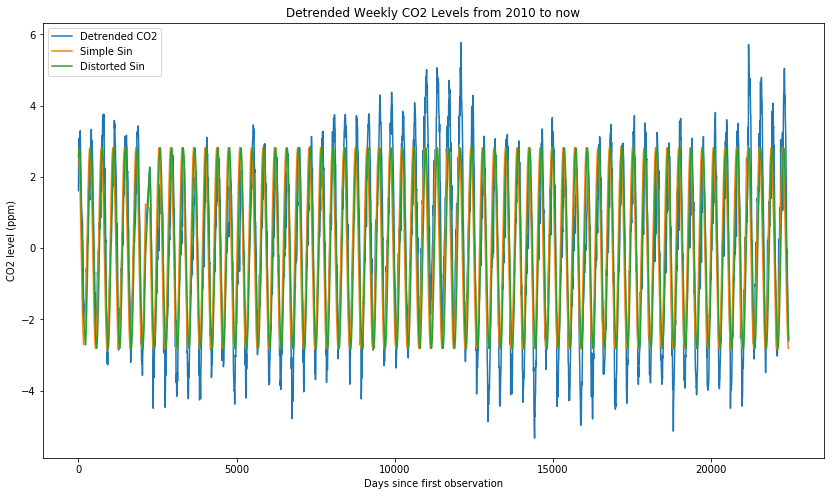

In [156]:
#Zoom in to see period more clearly
plt.figure(figsize=(14,8))
plt.plot(df["Ordinal_date"], df["Detrended_co2"], label="Detrended CO2")
plt.plot(df["Ordinal_date"], noiseless_simple_period,label="Simple Sin")
plt.plot(df["Ordinal_date"], noiseless_fancy_period,label="Distorted Sin")
plt.title('Detrended Weekly CO2 Levels from 2010 to now')
plt.xlabel("Days since first observation")
plt.ylabel('CO2 level (ppm)')
plt.legend(loc=0)
plt.show()

Judging from this visualization, the two models are basically indistinguishable. Both do a good job of capturing the period and phase shift of the detrended data. However, both models are conservative in the amplitude. It seems the amplitude at all timesteps for both our models is equal to the lowest and highest amplitudes in the real data at *any* timestep. If my previous hypothesis, that the varying vertical shift of the seasonality, is just noise as opposed to a predictable patters, then this might be considered a feature more so than a bug. Because, keep in mind, this is just the line given by the mean parameter estimates. In the actual model, there is posterior probability distribution over the amplitude of the seasonality. If we were to replicate the plot with every value in the Stan samples over the amplitude, then we would see both more extreme amplitudes and more conservative amplitudes. 

That said, it remains a central assumption of my model that the vertical shift is just noise.

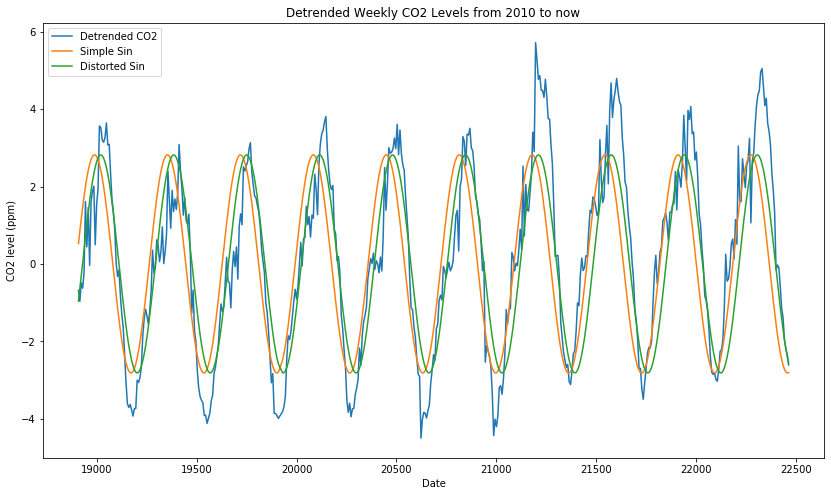

In [149]:
#Zoom in to see period more clearly
plt.figure(figsize=(14,8))
plt.plot(testing_subset["Ordinal_date"], testing_subset["Detrended_co2"], label="Detrended CO2")
plt.plot(testing_subset["Ordinal_date"], noiseless_simple_period.loc[recent],label="Simple Sin")
plt.plot(testing_subset["Ordinal_date"], noiseless_fancy_period.loc[recent],label="Distorted Sin")
plt.title('Detrended Weekly CO2 Levels from 2010 to now')
plt.xlabel("Date")
plt.ylabel('CO2 level (ppm)')
plt.legend(loc=0)
plt.show()

Looking at this zoomed in visualization, slight differences in the curves become apparent, althhough they are still substantially similar. That said, I personally have a preference for the distorted sin model, because it looks to be fitting the data better. Although the plotted slantedness, F=0.18, is only very slight it does seem to lend a better fit.

# Putting it all together, performing posterior predictive checks and prediciting future C02 levels

We combine the models together to give us our final model:

P(parameters|data) = N(A + B*time[i] + C*time[i]^2 + D*sin(constant*(time[i] + F*sin(time[i]) + E)), sigma))

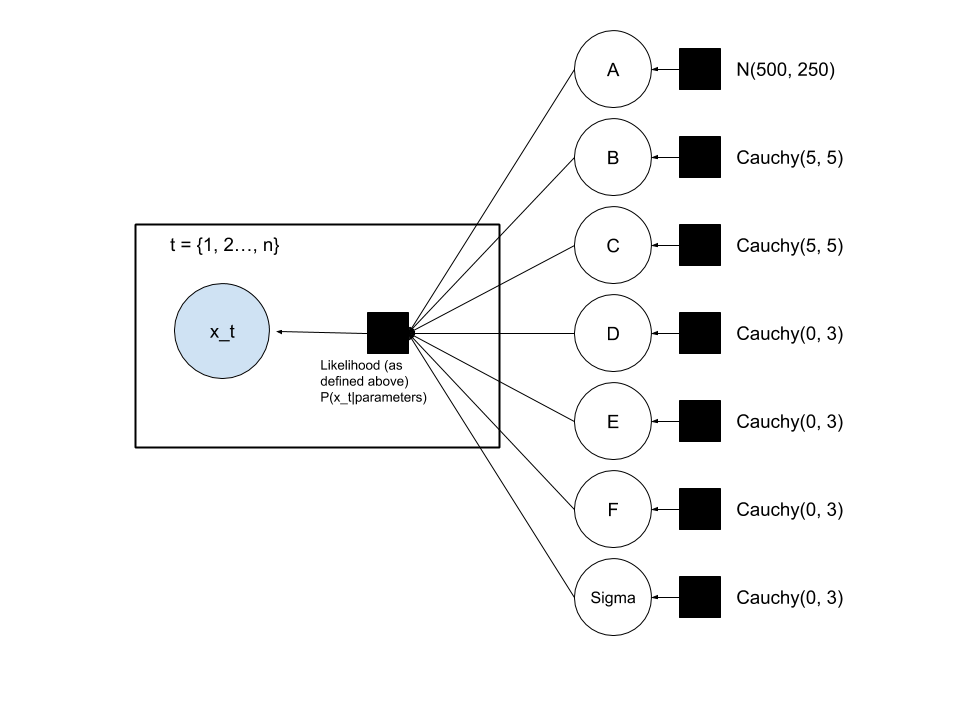

Priors where choosen to be very conservative and broad for two reasons. Firstly, we have a lot of data, so the model can be expected to produce tight posterior distributions independent of the width of the priors. Secondly, carefully selecting narrow priors is both risky–if we were to assign 0 prior probability to a region of the "real" posterior space–and time consuming. Something which, given the first point, did not seem worthwhile.

In [314]:
# We begin by creating the future times for which we want to generate data
future_df = pd.DataFrame()

#Generate the date of every Friday until the end of 2058
future_df["Future_date"] = pd.to_datetime(pd.date_range(df["Date"].max(), "2058-12-27", freq="W-FRI"))
#Create an ordinal representation
future_df["Future_ordinal_date"] = future_df["Future_date"].apply(lambda x: x.toordinal())
#Shift it backwards as much as df["Ordinal_dates"], 
#so that df["Future_ordinal_dates"].min() follows df["Ordinal_dates"].max()
future_df["Future_ordinal_date"] = future_df["Future_ordinal_date"] - (future_df["Future_ordinal_date"].min()-df["Ordinal_date"].max())+7

In [271]:
complete_stan_code =  """
data {
    int<lower=0> len_data;             // number of observation in data
    int<lower=0> len_future;          //Number of future dates to generate data for
    real<lower=0> time[len_future];      // time since first observation
    real carbon[len_data];            // Detrended Co2 level
    real constant;
}
parameters {
    real<lower=0> A;           // intercept
    real<lower=0> B;           // slope
    real<lower=0> C;           // coefficient for quadratic term
    real<lower=0> D;           // Amplitude
    real E;                    // Phase shift
    real F;                    // Slant on seasonality
    real<lower=0> sigma;       // noise / SD
} 
model {
    A ~ normal(500, 250); //Priors
    B ~ cauchy(5, 5);
    C ~ cauchy(5, 5);
    D ~ cauchy(0, 3);
    E ~ cauchy(0, 3);
    F ~ cauchy(0, 3);
    sigma ~ cauchy(0,2);
    for (i in 1:len_data) {
        carbon[i] ~ normal(A + time[i]*B + C*time[i]^2 + D*sin(constant*(time[i] + F*sin(time[i]) + E)), sigma); 
    }
}
generated quantities {   //Generate predicted future data
    real carbon_future[len_future];
    for (i in 1:len_future) {
        carbon_future[i] = normal_rng(A + time[i]*B + C*time[i]^2 + D*sin(constant*(time[i] + F*sin(time[i]) + E)), sigma);
    }
}
"""

#Compile model
complete_model = pystan.StanModel(model_code=complete_stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2fd3b538c3f36ac63269e9613549c302 NOW.


In [272]:
complete_stan_data = {
    "len_data" : df.shape[0], # number of observation in data
    "time" : np.concatenate((df["Ordinal_date"], future_df["Future_ordinal_date"])), # time since first observation
    "carbon" : df["Co2"], #Detrended Co2 level
    "constant": 2*np.pi/365.25, #Period
    "len_future": future_df.shape[0]+df.shape[0]
}

In [273]:
#Run model; Extract the Stan results
complete_model_results = complete_model.sampling(data=complete_stan_data)
complete_model_samples = complete_model_results.extract()
print(complete_model_results.stansummary(pars=["A", "B", "C","D", "E", "F", "sigma"], probs=[0.025, 0.5, 0.975]))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_2fd3b538c3f36ac63269e9613549c302.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
A     314.57  1.3e-3   0.05 314.47 314.57 314.67   1550    1.0
B     2.1e-3  3.1e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3   1202    1.0
C     9.7e-8 1.4e-114.7e-10 9.6e-8 9.7e-8 9.8e-8   1192    1.0
D       2.86  4.0e-4   0.02   2.81   2.86   2.91   3788    1.0
E      66.14  7.4e-3   0.51  65.15  66.14  67.12   4631    1.0
F       0.25    0.02   0.66  -1.02   0.24   1.59   1221    1.0
sigma   0.99  2.1e-4   0.01   0.96   0.99   1.01   3717    1.0

Samples were drawn using NUTS at Fri Dec 20 02:23:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Evaluating the model: Posterior predictive testing

Approach: We have observed the CO2 level from 1958 until late 2019. We use the model to generate sample for this same period and evaluate the fidelity of the generated data.

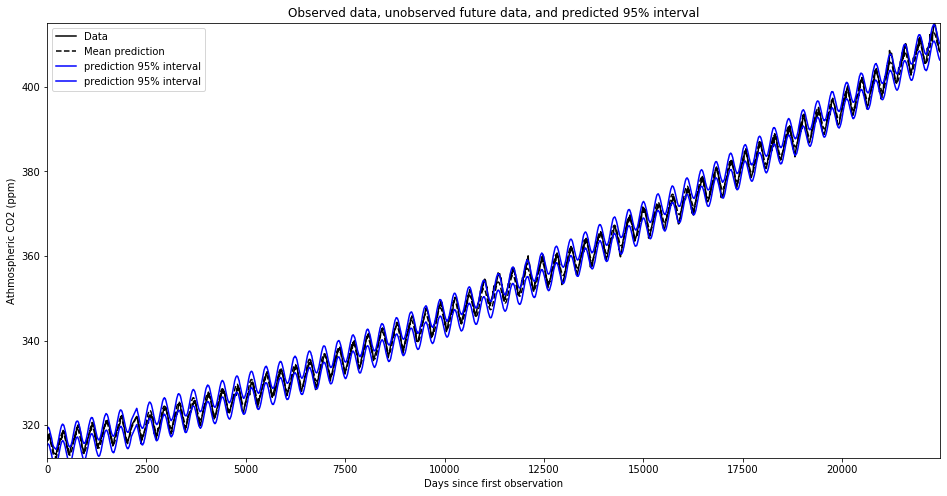

In [291]:
#Code adapted from session 14.1

prediction = complete_model_samples['carbon_future']
#Extract the samples of generated data for which real data is observed
df["Simulated_co2"] = prediction.mean(axis=0)[:df.shape[0]]

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(16, 8))
plt.plot(df["Ordinal_date"], df["Co2"], 'k-', label='Data')
plt.plot(df["Ordinal_date"], df["Simulated_co2"] , 'k--', label='Mean prediction')

#Window size
plt.xlim(0, df["Ordinal_date"].max())
plt.ylim(min(df["Simulated_co2"].min(), df["Co2"].min()),max(df["Simulated_co2"].max(), df["Co2"].max()))

#Lower_bound of predction interval
plt.plot(df["Ordinal_date"], prediction_interval[0,:df.shape[0]],
    'b-', label='prediction 95% interval')

#Upper bound of predction interval
plt.plot(df["Ordinal_date"], prediction_interval[1,:df.shape[0]],
    'b-', label='prediction 95% interval')


plt.xlabel('Days since first observation')
plt.ylabel('Athmospheric CO2 (ppm)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

The image is admittedly crude, but visually it seems like the model is doing a good job generating data that is similar to the real data. To get a better understanding of where they differ, let's plot the residuals. That is, the difference between the mean prediction and the real data for each observation. We want magnitude of the residuals to be small.

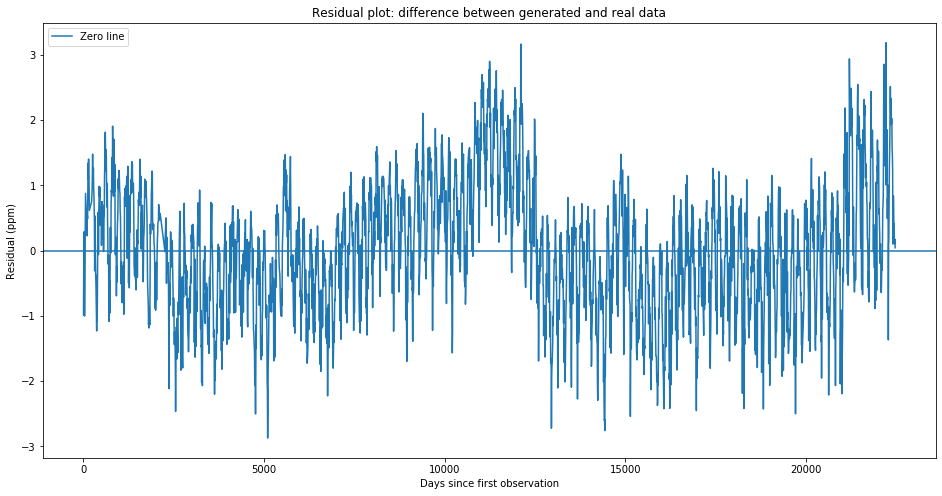

In [296]:
residuals = df["Co2"]-df["Simulated_co2"]

plt.figure(figsize=(16, 8))
plt.plot(df["Ordinal_date"], residuals)



plt.xlabel('Days since first observation')
plt.ylabel('Residual (ppm)')
plt.axhline(0,label="Zero line")
plt.legend()
plt.title("Residual plot: difference between generated and real data")
plt.show()

The magnitude of residuals is small–all in the range +-3, which is small relative to a 300+ppm and quickly increasing CO2 levels–and there are no notable outliers. This means I am confident that this model captures the components of the data that are relevant to making projections about the future.

On a side note, in this case, because the slope is so steep relative to the amplitude of the seasonality, I would argue that capturing the trend is the important thing.

This residual plot is quite familiar–we have seen something very similar when looking at the detrended data. I suspect the reason the residual remains, is that we have choosen not to model this vertical shift of the period as I thought it to be random. 

## Predicting Athmospheric CO2 levels until 2058: when are the CO2 levels likely to reach dangerous levels?

Approach: When does the lower bound of the predicted CO2 confidence interval intersect the horizontal line indicating dangerous X ppm threshhold. This is equivalent to finding the point in time in which the model predict there to be a 97.5% probability (97.5% of the probability mass has higher values than the lower bound of a 95% confidence interval) of the CO2 levels reaching the threshold.

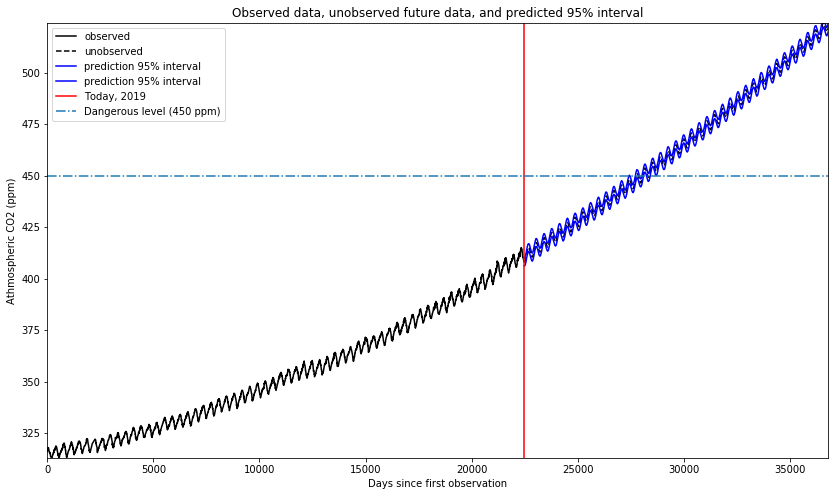

In [288]:
#Code adapted from session 14.1

#Extract future component of carbon_future samples
future_df["Future_co2"] = prediction.mean(axis=0)[df.shape[0]:]


# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(14, 8))
plt.plot(df["Ordinal_date"], df["Co2"], 'k-', label='observed')
plt.plot(future_df["Future_ordinal_date"], future_df["Future_co2"] , 'k--', label='unobserved')

#Window size
plt.xlim(0, future_df["Future_ordinal_date"].max())
plt.ylim(df["Co2"].min(),future_df["Future_co2"] .max())

#Lower_bound of predction interval
plt.plot(future_df["Future_ordinal_date"], prediction_interval[0,df.shape[0]:],
    'b-', label='prediction 95% interval')

#Upper bound of predction interval
plt.plot(future_df["Future_ordinal_date"], prediction_interval[1,df.shape[0]:],
    'b-', label='prediction 95% interval')


plt.axvline(df["Ordinal_date"].max(), color='red', label="Today, 2019")
plt.axhline(450, linestyle='-.',label="Dangerous level (450 ppm)")
plt.xlabel('Days since first observation')
plt.ylabel('Athmospheric CO2 (ppm)')
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [313]:
from datetime import timedelta  
#Find specific date on which the lower bound of the prediction first intersects 450ppm
i = np.where(prediction_interval[0,df.shape[0]:]>=450)[0][0]
ordinal_date = future_df["Future_ordinal_date"].loc[i]
df["Date"].min() + timedelta(days=int(ordinal_date)) 

Timestamp('2035-03-04 00:00:00')

For the purposes of predicting when 

Looking at the predicted future development of athmospheric CO2, it seems to be a perfect extrapolation of the historical data. The width of the 95% prediction interval does not change notably as we continue on into the future. I interpret as the model saying, "I am really sure about these parameter values" because none of the training data give any reason to suspect otherwise: the noise is very limited, the trend is nicely quadratic and the amplitude and period of the seasonality has remained practically the same since 1958 until now. The model thinks this will continue.

I think this is not realistic, and I would be very careful in interpreting the "there is a 97.5% chance that the athmospheric CO2 will reach dangerous levels by 2035"-statistic. Specifically, it must be emphasised that this is valid only on the assumption that the development of athmosperic CO2 levels, caused by human fossil fuel consumption, continues along the same traectory as it has since data first first collected. Of course, in my view, we cannot be confident about this–and that should be reflected in the prediction intervals of the model! In particular, as the airquality gradually degrades and the impending climate doomsday draws ever-closer, I suspect people's inclination towards radical climate action will increase commensurately.

This is, in my view, the primary short-coming of this mdoel.